**Applied Machine Learning - Homework 4 (Question 1)**

**Group Members:**

1. Yash Takte
2. Sejal Nimkar
3. Niranjan Tapasvi
4. Neha Kothavade

In [2]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from transformers import AutoModelForZeroShotImageClassification, AutoProcessor
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

# **From Huggingface (https://huggingface.co) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer).** 

In [4]:
# CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
model = AutoModelForZeroShotImageClassification.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)

In [5]:
# Model Architecture
print("Model Architecture:")
print(model)

Model Architecture:
CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): Laye

## Model Type
The downloaded model is a **CLIP (Contrastive Language-Image Pretraining)** model, which uses:
- A **Vision Transformer (ViT)** for processing images.
- A **Text Transformer** for processing text.
  
The two models are trained to map both image and text data into a common space for similarity comparison.

In [7]:
# Vision Transformer (ViT) Backbone 
vit_backbone = model.vision_model  
print("\nVision Backbone Architecture:")
print(vit_backbone)


Vision Backbone Architecture:
CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (position_embedding): Embedding(257, 1024)
  )
  (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-23): 24 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_fea

In [8]:
# Encoder part of ViT 
vision_encoder = vit_backbone.encoder
print("\nVision Encoder Structure:")
print(vision_encoder)


Vision Encoder Structure:
CLIPEncoder(
  (layers): ModuleList(
    (0-23): 24 x CLIPEncoderLayer(
      (self_attn): CLIPSdpaAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): CLIPMLP(
        (activation_fn): QuickGELUActivation()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      )
      (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)


## Vision Model (CLIPVisionTransformer)
This model processes **images** and uses a **Vision Transformer** architecture.

### Patch Embedding:
- Converts image patches into feature vectors.
- **Parameters**: Conv2D weights for patch embedding. The image is divided into **14x14** patches, and each patch is converted into a **1024-dimensional vector**.

### Position Embedding:
- Adds spatial information to the patches.
- **Parameters**: 257 learnable position embeddings (size: 1024).

### Encoder (24 layers):
The encoder consists of **24 Transformer layers**, each containing:

#### Self-Attention Mechanism:
- Learns the relationship between patches.
- **Parameters**:
  - **Key (K)**, **Query (Q)**, and **Value (V)** matrices of size **1024x1024**.
  - These matrices are used to compute attention scores between different image patches.

#### MLP (Multi-Layer Perceptron):
- Refines the features.
- **Parameters**: Dense layers where features are expanded from **1024 → 4096 → 1024**.

#### LayerNorm:
- Normalizes activations for stability and faster convergence.

### Projection Layer:
- Maps the features to a **768-dimensional space** to align with the text model.
- **Parameters**: Weight matrix of size **1024x768**.

In [10]:
print("\nVision Encoder Attributes:")
print(dir(vision_encoder))


Vision Encoder Attributes:
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_is_hf_initialized', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set',

In [11]:
# Number of layers in the vision encoder
vision_encoder_layers = len(vision_encoder.layers)
print(f"\nNumber of Layers in Vision Encoder: {vision_encoder_layers}")


Number of Layers in Vision Encoder: 24


In [12]:
# Counting parameters in a given layer
def count_parameters(layer):
    params = sum(p.numel() for p in layer.parameters() if p.requires_grad)
    return params

In [13]:
# Vision Encoder Layer Components
for idx, layer in enumerate(vision_encoder.layers):  
    print(f"\nVision Encoder Layer {idx + 1}:")
    
    # Attention mechanism components within the layer
    print(f"  Attention Layer:")
    print(f"    Key Projection (k_proj): {layer.self_attn.k_proj}")
    print(f"    Value Projection (v_proj): {layer.self_attn.v_proj}")
    print(f"    Query Projection (q_proj): {layer.self_attn.q_proj}")
    print(f"    Output Projection (out_proj): {layer.self_attn.out_proj}")
    
    # MLP component within the layer
    print(f"  MLP Layer:")
    print(f"    Fully Connected Layer 1 (fc1): {layer.mlp.fc1}")
    print(f"    Fully Connected Layer 2 (fc2): {layer.mlp.fc2}")

    # Layer normalization components
    print(f"  Layer Normalization 1: {layer.layer_norm1}")
    print(f"  Layer Normalization 2: {layer.layer_norm2}")
    
    # Parameters per layer
    print(f"  Parameters in Attention Mechanism:")
    print(f"    k_proj: {count_parameters(layer.self_attn.k_proj)} parameters")
    print(f"    v_proj: {count_parameters(layer.self_attn.v_proj)} parameters")
    print(f"    q_proj: {count_parameters(layer.self_attn.q_proj)} parameters")
    print(f"    out_proj: {count_parameters(layer.self_attn.out_proj)} parameters")

    print(f"  Parameters in MLP Layer:")
    print(f"    fc1: {count_parameters(layer.mlp.fc1)} parameters")
    print(f"    fc2: {count_parameters(layer.mlp.fc2)} parameters")
    
    print(f"  Parameters in Layer Normalization:")
    print(f"    layer_norm1: {count_parameters(layer.layer_norm1)} parameters")
    print(f"    layer_norm2: {count_parameters(layer.layer_norm2)} parameters")


Vision Encoder Layer 1:
  Attention Layer:
    Key Projection (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
    Value Projection (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
    Query Projection (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
    Output Projection (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
  MLP Layer:
    Fully Connected Layer 1 (fc1): Linear(in_features=1024, out_features=4096, bias=True)
    Fully Connected Layer 2 (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  Layer Normalization 1: LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  Layer Normalization 2: LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  Parameters in Attention Mechanism:
    k_proj: 1049600 parameters
    v_proj: 1049600 parameters
    q_proj: 1049600 parameters
    out_proj: 1049600 parameters
  Parameters in MLP Layer:
    fc1: 4198400 parameters
    fc2: 4195328 parameters
  Parameters

In [14]:
# Total number of parameters in the Vision Transformer model
total_params_vit = sum(p.numel() for p in vit_backbone.parameters() if p.requires_grad)
print(f"\nTotal Number of Parameters in Vision Transformer: {total_params_vit}")


Total Number of Parameters in Vision Transformer: 303179776


In [15]:
# Text Transformer Backbone 
text_backbone = model.text_model  
print("\nText Backbone Architecture:")
print(text_backbone)


Text Backbone Architecture:
CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 768)
    (position_embedding): Embedding(77, 768)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )


In [16]:
# Encoder part of ViT 
text_encoder = model.text_model.encoder
print("\nText Encoder Structure:")
print(text_encoder)


Text Encoder Structure:
CLIPEncoder(
  (layers): ModuleList(
    (0-11): 12 x CLIPEncoderLayer(
      (self_attn): CLIPSdpaAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=True)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): CLIPMLP(
        (activation_fn): QuickGELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)


## Text Model (CLIPTextTransformer)
This model processes **text** data and uses a **Transformer-based** architecture similar to the Vision model.

### Token Embedding:
- Converts tokens (words) into feature vectors.
- **Parameters**: 49408 vocabulary tokens, each mapped to a **768-dimensional vector**.

### Position Embedding:
- Adds positional information to the tokens.
- **Parameters**: 77 learnable position embeddings (size: 768).

### Encoder (12 layers):
The encoder consists of **12 Transformer layers**, each containing:

#### Self-Attention Mechanism:
- Learns the relationship between words.
- **Parameters**:
  - **Key (K)**, **Query (Q)**, and **Value (V)** matrices of size **768x768**.

#### MLP (Multi-Layer Perceptron):
- Expands features.
- **Parameters**: Dense layers that expand from **768 → 3072 → 768**.

#### LayerNorm:
- Stabilizes activations for better training.

### Projection Layer:
- Maps the text features to the same **768-dimensional space** as the image model.
- **Parameters**: Weight matrix of size **768x768**.

In [18]:
print("\nText Encoder Attributes:")
print(dir(text_encoder))


Text Encoder Attributes:
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_is_hf_initialized', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '

In [19]:
# Number of layers in the text encoder
text_encoder_layers = len(text_encoder.layers)
print(f"\nNumber of Layers in Text Encoder: {text_encoder_layers}")


Number of Layers in Text Encoder: 12


In [20]:
# Text Encoder Layer Components
for idx, layer in enumerate(text_encoder.layers):  
    print(f"\nText Encoder Layer {idx + 1}:")
    
    # Self-attention components (Q, K, V matrices)
    self_attn = layer.self_attn
    print(f"  - Q Matrix: {self_attn.q_proj.weight.shape}")
    print(f"  - K Matrix: {self_attn.k_proj.weight.shape}")
    print(f"  - V Matrix: {self_attn.v_proj.weight.shape}")
    print(f"  - Output Projection (out_proj): {self_attn.out_proj.weight.shape}")
    
    # Feedforward layers (MLP)
    print(f"  - Feedforward Layers:")
    print(f"    - Dense Layer 1: {layer.mlp.fc1.weight.shape}")
    print(f"    - Dense Layer 2: {layer.mlp.fc2.weight.shape}")
    
    # Layer normalization components
    print(f"  - Layer Normalization 1: {layer.layer_norm1.weight.shape}")
    print(f"  - Layer Normalization 2: {layer.layer_norm2.weight.shape}")
    
    # Parameters per layer
    print(f"  Parameters in Self-Attention Mechanism:")
    print(f"    Q Matrix: {count_parameters(self_attn.q_proj)} parameters")
    print(f"    K Matrix: {count_parameters(self_attn.k_proj)} parameters")
    print(f"    V Matrix: {count_parameters(self_attn.v_proj)} parameters")
    print(f"    Output Projection (out_proj): {count_parameters(self_attn.out_proj)} parameters")
    
    print(f"  Parameters in Feedforward (MLP) Layers:")
    print(f"    Dense Layer 1 (fc1): {count_parameters(layer.mlp.fc1)} parameters")
    print(f"    Dense Layer 2 (fc2): {count_parameters(layer.mlp.fc2)} parameters")
    
    print(f"  Parameters in Layer Normalization:")
    print(f"    Layer Norm 1: {count_parameters(layer.layer_norm1)} parameters")
    print(f"    Layer Norm 2: {count_parameters(layer.layer_norm2)} parameters")


Text Encoder Layer 1:
  - Q Matrix: torch.Size([768, 768])
  - K Matrix: torch.Size([768, 768])
  - V Matrix: torch.Size([768, 768])
  - Output Projection (out_proj): torch.Size([768, 768])
  - Feedforward Layers:
    - Dense Layer 1: torch.Size([3072, 768])
    - Dense Layer 2: torch.Size([768, 3072])
  - Layer Normalization 1: torch.Size([768])
  - Layer Normalization 2: torch.Size([768])
  Parameters in Self-Attention Mechanism:
    Q Matrix: 590592 parameters
    K Matrix: 590592 parameters
    V Matrix: 590592 parameters
    Output Projection (out_proj): 590592 parameters
  Parameters in Feedforward (MLP) Layers:
    Dense Layer 1 (fc1): 2362368 parameters
    Dense Layer 2 (fc2): 2360064 parameters
  Parameters in Layer Normalization:
    Layer Norm 1: 1536 parameters
    Layer Norm 2: 1536 parameters

Text Encoder Layer 2:
  - Q Matrix: torch.Size([768, 768])
  - K Matrix: torch.Size([768, 768])
  - V Matrix: torch.Size([768, 768])
  - Output Projection (out_proj): torch.Size([

In [21]:
# Total number of parameters in the Text Transformer model
total_params_text = sum(p.numel() for p in text_backbone.parameters() if p.requires_grad)
print(f"\nTotal Number of Parameters in Text Transformer: {total_params_text}")


Total Number of Parameters in Text Transformer: 123060480


In [22]:
# Total number of parameters in the model
num_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal Number of Parameters in the CLIP Model: {num_params / 1e6:.2f} million")


Total Number of Parameters in the CLIP Model: 427.62 million


In [23]:
# Total number of layers in both encoders
total_layers = text_encoder_layers + vision_encoder_layers
print(f"Total Layers in CLIP Model (Text + Vision Encoder): {total_layers}")

Total Layers in CLIP Model (Text + Vision Encoder): 36


## Key Parameters Breakdown

### Self-Attention Mechanism:
- Uses **Key (K)**, **Query (Q)**, and **Value (V)** matrices to compute attention scores.
  - **K, Q, V matrices**: Used in both image and text encoders to determine how different parts of the input should attend to each other.

### MLP (Dense Layers):
- Expands and projects features during the encoding process.
- **Parameters**: The MLP layers in both the vision and text models have weights for each connection between the neurons.

### Position Embeddings:
- These embeddings are added to input tokens or image patches to provide information about the position of the token/patch in the sequence (image or text).

### Projection Layers:
- Aligns image and text features into the same space for comparison.

# **The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Quantify model accuracy for each of the five conditions.**

In [26]:
# Categories and Conditions
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["blurred", "features", "geons", "realistic", "silhouettes"]

image_folder = "D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 4 Q1\\image_files\\v0"

In [27]:
# Extract category from image name
def extract_category_from_filename(filename):
    for category in categories:
        if category.lower() in filename.lower():
            return category
    return None  

In [28]:
# Count images for each category in each condition
def count_categories_for_conditions(image_folder, categories, conditions):
    category_counts = {condition: {category: 0 for category in categories} for condition in conditions}
    
    for condition in conditions:
        condition_folder = os.path.join(image_folder, condition)
        
        # Loop through all images for each condition
        for image_name in os.listdir(condition_folder):
            image_path = os.path.join(condition_folder, image_name)
            
            # Extract the actual category from the image name
            actual_category = extract_category_from_filename(image_name)
            if actual_category:
                category_counts[condition][actual_category] += 1
    
    return category_counts
    
category_counts = count_categories_for_conditions(image_folder, categories, conditions)

# Category counts for each condition
for condition, counts in category_counts.items():
    print(f"Category Counts for {condition.capitalize()}:")
    for category, count in counts.items():
        print(f"  {category}: {count}")

Category Counts for Blurred:
  airplane: 6
  car: 5
  chair: 6
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Category Counts for Features:
  airplane: 6
  car: 5
  chair: 5
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Category Counts for Geons:
  airplane: 8
  car: 8
  chair: 7
  cup: 8
  dog: 7
  donkey: 7
  duck: 7
  hat: 7
Category Counts for Realistic:
  airplane: 5
  car: 5
  chair: 5
  cup: 5
  dog: 6
  donkey: 5
  duck: 5
  hat: 5
Category Counts for Silhouettes:
  airplane: 5
  car: 5
  chair: 5
  cup: 6
  dog: 4
  donkey: 5
  duck: 5
  hat: 5


In [29]:
# Evaluate model for each condition
def evaluate_model_for_conditions(image_folder, categories, conditions, model, processor):
    accuracies = {condition: 0 for condition in conditions}
    
    for condition in conditions:
        correct_count = 0
        total_count = 0
        
        # Loop through all images for each condition
        condition_folder = os.path.join(image_folder, condition)
        
        for image_name in os.listdir(condition_folder):
            image_path = os.path.join(condition_folder, image_name)
            
            image = Image.open(image_path).convert("RGB")
            image = image.resize((224, 224))
            
            # Extract the actual category from the image name
            actual_category = extract_category_from_filename(image_name)
            if actual_category is None:
                continue  
            
            # Process the image and text labels
            inputs = processor(images=image, text=categories, return_tensors="pt", padding=True)
            
            # Model predictions
            with torch.no_grad():
                outputs = model(**inputs)
            
            # Logits
            logits_per_image = outputs.logits_per_image  # Similarity between image and text
            max_logit_idx = logits_per_image.argmax().item()
            
            #Predicted category based on the highest similarity
            predicted_category = categories[max_logit_idx]
            
            if predicted_category == actual_category:
                correct_count += 1
            total_count += 1
        
        accuracy = correct_count / total_count if total_count > 0 else 0
        accuracies[condition] = accuracy
        print(f"Accuracy for condition '{condition}': {accuracy * 100:.2f}%")
    
    return accuracies

In [30]:
# Evaluating model and printing accuracies
accuracies = evaluate_model_for_conditions(image_folder, categories, conditions, model, processor)

print("\nOverall Accuracies for each condition:")
for condition, accuracy in accuracies.items():
    print(f"{condition.capitalize()}: {accuracy * 100:.2f}%")

Accuracy for condition 'blurred': 80.95%
Accuracy for condition 'features': 95.12%
Accuracy for condition 'geons': 50.85%
Accuracy for condition 'realistic': 97.56%
Accuracy for condition 'silhouettes': 95.00%

Overall Accuracies for each condition:
Blurred: 80.95%
Features: 95.12%
Geons: 50.85%
Realistic: 97.56%
Silhouettes: 95.00%


# **In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gae)**

**The accuracy estimates for the baby's performance were approximated by observing the bar plot in the ModelVsBaby paper (Figure 3A).**

Realistic: **85.00%**

Silhouettes: **78.00%**

Geons: **58.00%**

Blurred: **56.00%**

Features: **55.00%**

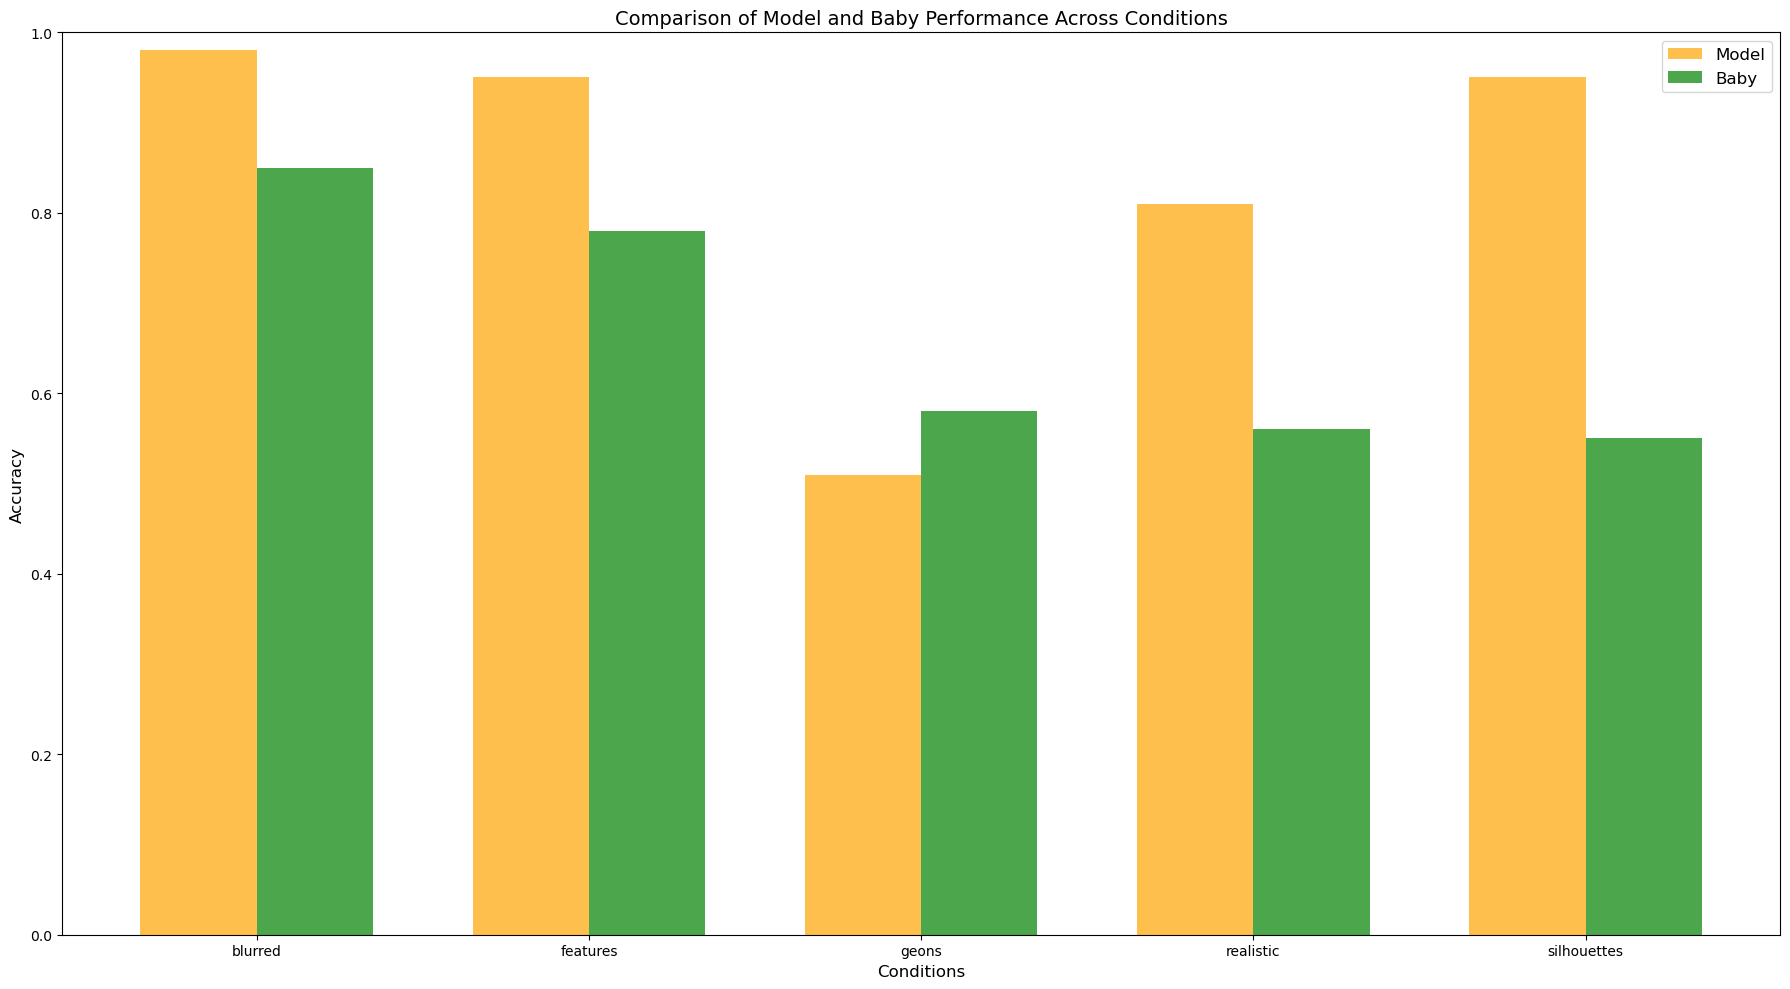

In [33]:
condition = ["Realistic", "Silhouettes", "Geons", "Blurred", "Features"]

model_accuracies = [0.98, 0.95, 0.51, 0.81, 0.95]  
baby_accuracies = [0.85, 0.78, 0.58, 0.56, 0.55]   

bar_width = 0.35

x = np.arange(len(condition))

plt.figure(figsize=(18, 10))
plt.bar(x - bar_width/2, model_accuracies, bar_width, label='Model', color='orange', alpha=0.7)
plt.bar(x + bar_width/2, baby_accuracies, bar_width, label='Baby', color='green', alpha=0.7)
plt.xlabel("Conditions", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Comparison of Model and Baby Performance Across Conditions", fontsize=14)
plt.xticks(x, conditions, fontsize=10)
plt.ylim(0, 1.0)
plt.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

When comparing the performance of the model and babies across five conditions, we observe the following:

**1. The model consistently outperforms babies in most conditions:**

**Realistic** (Model: 97.56% vs. Baby: 85.00%)

**Silhouettes** (Model: 95.00% vs. Baby: 78.00%)

**Blurred** (Model: 80.95% vs. Baby: 56.00%)

**Features** (Model: 95.12% vs. Baby: 55.00%)

**2. In the 'Geons' condition, the model's performance (50.85%) is slightly lower than that of babies (58.00%), indicating a slight disadvantage in this specific task.**

Overall, the model demonstrates superior performance in four out of the five conditions, suggesting that it is more effective than babies in recognizing patterns in most scenarios.

# **From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gae. but no need for color coding of bounding boxes).** 

In [36]:
# Extracting embeddings from the final layer of the vision encoder
def extract_vision_embeddings(image_folder, model, processor, categories, conditions):
    embeddings = []
    images_list = []
    labels = []

    for condition in conditions:
        condition_folder = os.path.join(image_folder, condition)
        
        for image_name in os.listdir(condition_folder):
            image_path = os.path.join(condition_folder, image_name)
            image = Image.open(image_path).convert("RGB")
            
            image = image.resize((224, 224))
            
            inputs = processor(images=image, return_tensors="pt", padding=True)
            
            with torch.no_grad():
                vision_outputs = model.vision_model(**inputs)
                
                # Final layer output before projection
                vision_embedding = vision_outputs.last_hidden_state.mean(dim=1).squeeze()
                
            embeddings.append(vision_embedding)
            images_list.append(image)

            actual_category = extract_category_from_filename(image_name)
            labels.append(actual_category)
    
    return torch.stack(embeddings), images_list, labels

In [37]:
# Applying TSNE & Plotting
def apply_tsne_and_plot_with_images(embeddings, images_list, labels, num_images=100, zoom=0.5):
    
    embeddings_normalized = StandardScaler().fit_transform(embeddings.cpu().numpy())

    pca = PCA(0.90)  
    embeddings_pca_reduced = pca.fit_transform(embeddings_normalized)
    num_components_90 = pca.n_components_
    print(f"Number of components that explain at least 90% of the variance: {num_components_90}")

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()

    plt.figure(figsize=(8, 6))

    # Cumulative explained variance
    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='g', label='Cumulative Explained Variance')
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(embeddings_pca_reduced)

    # Normalizing t-SNE results 
    x_min, x_max = tsne_results.min(0), tsne_results.max(0)
    tsne_norm = (tsne_results - x_min) / (x_max - x_min)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title("t-SNE Visualization of Embeddings")

    sample_indices = np.linspace(0, len(images_list) - 1, num_images, dtype=int)

    for idx in sample_indices:
        point = tsne_norm[idx]
        image = images_list[idx]
        imagebox = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(imagebox, point, frameon=False)
        ax.add_artist(ab)

    plt.axis("off")
    plt.show()

In [38]:
embeddings, images_list, labels = extract_vision_embeddings(image_folder, model, processor, categories, conditions)

Number of components that explain at least 90% of the variance: 76


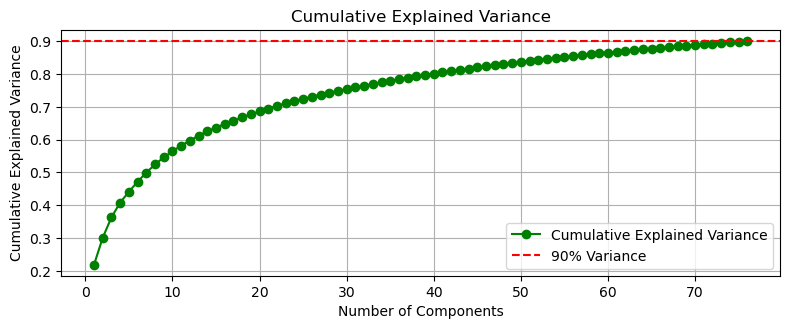

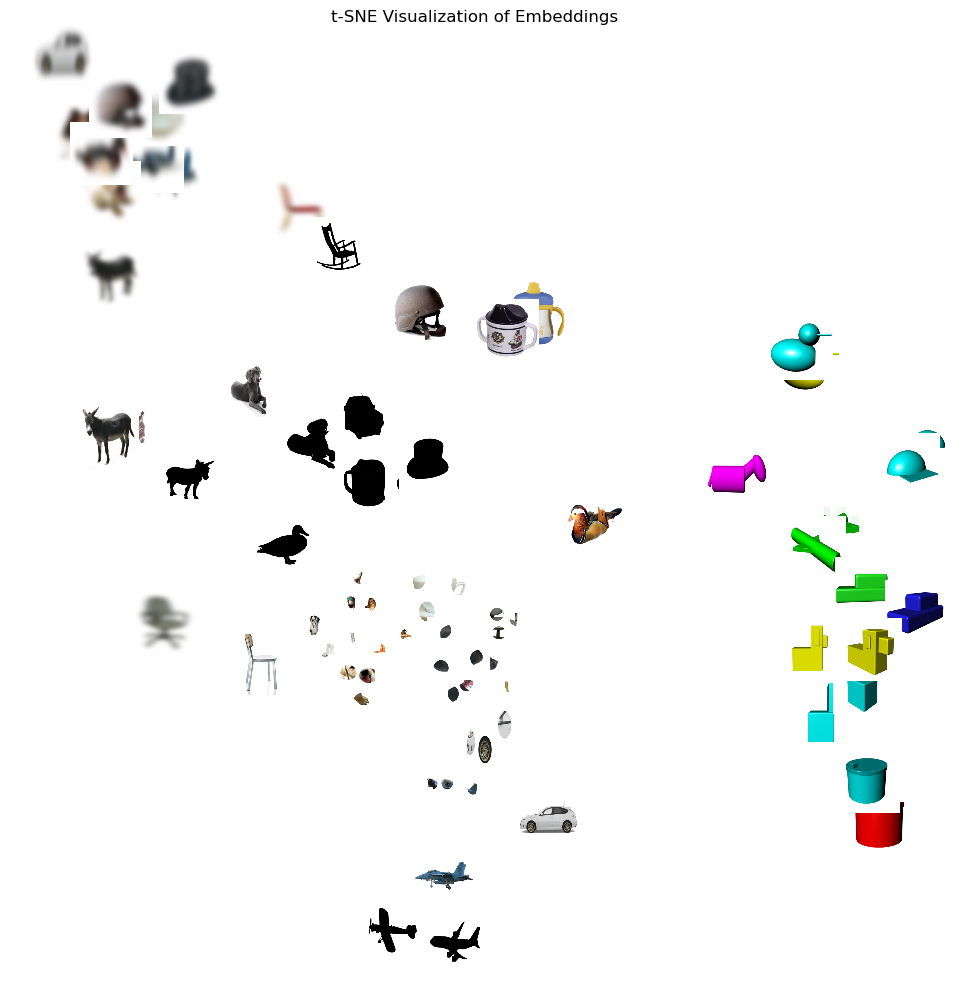

In [39]:
apply_tsne_and_plot_with_images(embeddings, images_list, labels, num_images=60, zoom=0.20)

**This t-SNE plot visualizes the embeddings of 60 images, clustering them based on visual similarity in a reduced two-dimensional space, where we are using only 60 images instead of the full dataset for visualization purposes.**

**References**

1. https://openai.com/chatgpt/
2. https://www.geeksforgeeks.org/
3. https://stackoverflow.com/